In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


train_seg_dir="/content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/Training/Segmentation"
train_no_seg_dir="/content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/Training/No_segmentation"
train_dir="/content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/Training"
validation_dir="/content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/Validation"

In [ ]:
import tensorflow as tf

tf.get_logger().setLevel('INFO')

In [ ]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,Dropout,Flatten,Dense
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision,Accuracy

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
H=256
W=256
dim=(H,W)

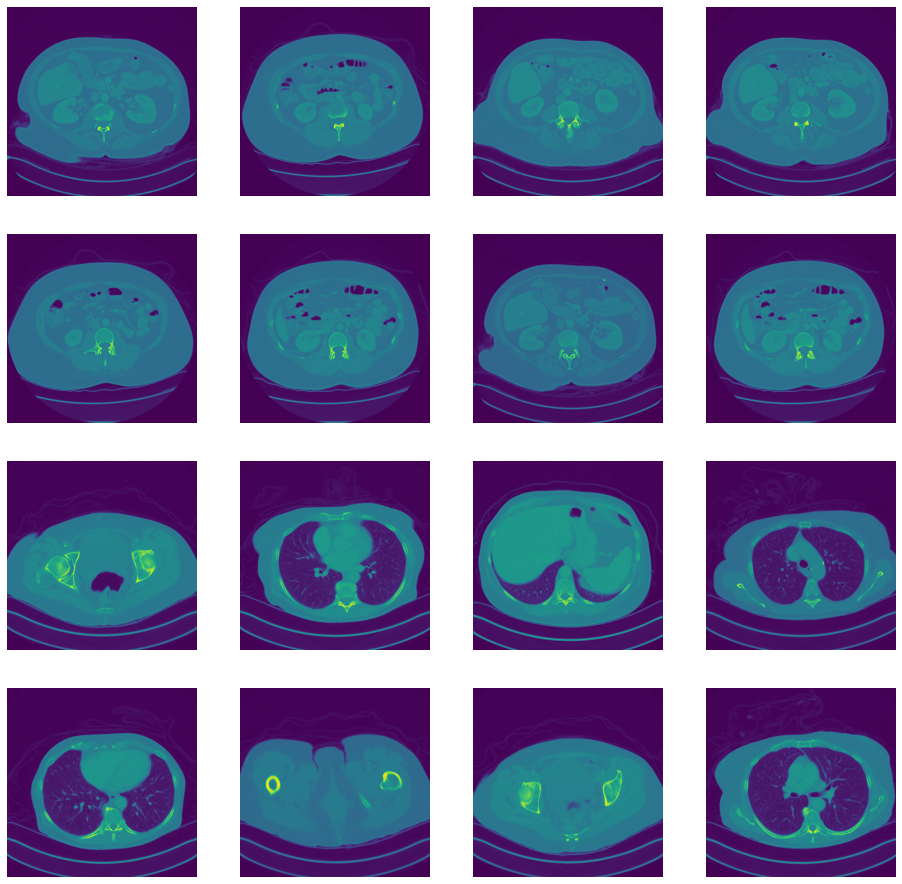

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_seg_fnames = os.listdir( train_seg_dir )
train_no_seg_fnames = os.listdir( train_no_seg_dir )


seg_pix = [os.path.join(train_seg_dir, fname)
                for fname in train_seg_fnames[ pic_index-8:pic_index]
               ]

no_seg_pix = [os.path.join(train_no_seg_dir, fname)
                for fname in train_no_seg_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(seg_pix+no_seg_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7964 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3120 files belonging to 2 classes.


In [ ]:
# tf.keras.backend.clear_session()

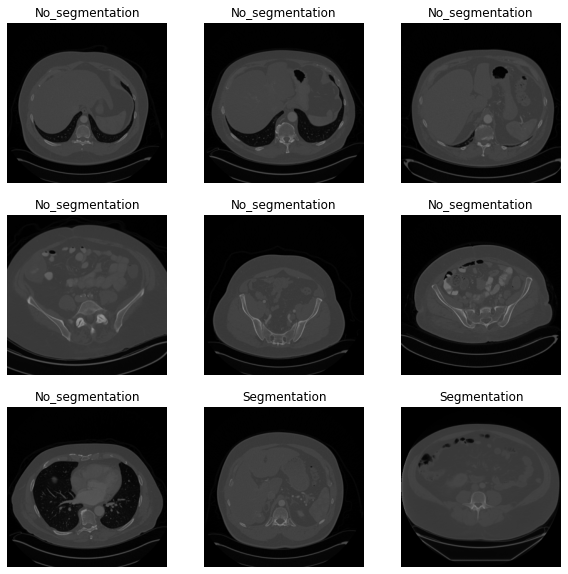

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


# clear_output()

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 79
Number of test batches: 19


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = VGG16(input_shape = (256, 256, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)




(32, 8, 8, 512)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

# clear_output()

79/79 [==============================] - 389s 4s/step - loss: 1.5809 - accuracy: 0.3945


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.58
initial accuracy: 0.39


In [ ]:
model_weights = "/content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/modelvgg16.h5"
csv_weights = "/content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/modelvgg16.csv"

callbacks = [
    ModelCheckpoint( model_weights,verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.00001, patience=2, min_lr=1e-7, verbose=1),
    TensorBoard(),
    CSVLogger(csv_weights),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False),
    ]

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,callbacks=callbacks)



Epoch 1/10
249/249 [==============================] - ETA: 0s - loss: 1.6438 - accuracy: 0.4538
Epoch 1: val_loss improved from inf to 1.10202, saving model to /content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/modelvgg16.h5
249/249 [==============================] - 711s 3s/step - loss: 1.6438 - accuracy: 0.4538 - val_loss: 1.1020 - val_accuracy: 0.4339 - lr: 1.0000e-05
Epoch 2/10
249/249 [==============================] - ETA: 0s - loss: 1.2402 - accuracy: 0.5196
Epoch 2: val_loss improved from 1.10202 to 0.95028, saving model to /content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/modelvgg16.h5
249/249 [==============================] - 75s 296ms/step - loss: 1.2402 - accuracy: 0.5196 - val_loss: 0.9503 - val_accuracy: 0.5279 - lr: 1.0000e-05
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 1.0794 - accuracy: 0.5679
Epoch 3: val_loss improved from 0.95028 to 0.93347, saving model to /content/drive/MyDrive/FYP/Dataset/classif

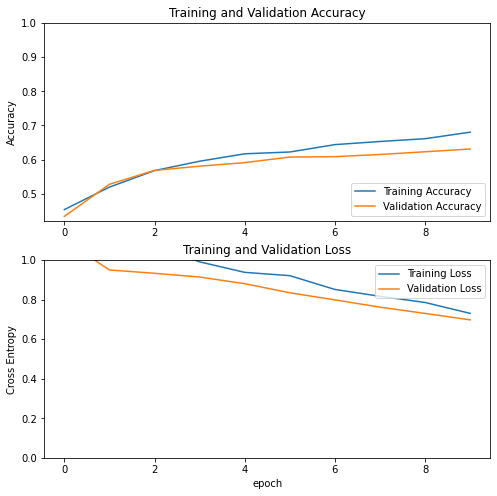

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,callbacks=callbacks)



Epoch 10/30
249/249 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9323
Epoch 10: val_loss improved from 0.69776 to 0.64796, saving model to /content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/modelvgg16.h5
249/249 [==============================] - 182s 700ms/step - loss: 0.1618 - accuracy: 0.9323 - val_loss: 0.6480 - val_accuracy: 0.8236 - lr: 1.0000e-05
Epoch 11/30
249/249 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9765
Epoch 11: val_loss improved from 0.64796 to 0.53146, saving model to /content/drive/MyDrive/FYP/Dataset/classification/Classification_FINAL/modelvgg16.h5
249/249 [==============================] - 171s 684ms/step - loss: 0.0573 - accuracy: 0.9765 - val_loss: 0.5315 - val_accuracy: 0.8443 - lr: 1.0000e-05
Epoch 12/30
249/249 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9863
Epoch 12: val_loss improved from 0.53146 to 0.45795, saving model to /content/drive/MyDrive/FYP/D

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

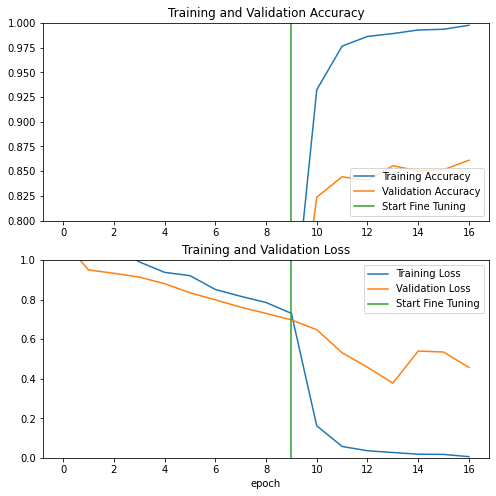

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

19/19 [==============================] - 5s 213ms/step - loss: 0.3500 - accuracy: 0.8734
Test accuracy : 0.8733552694320679


Predictions:
 [1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
Labels:
 [1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1]


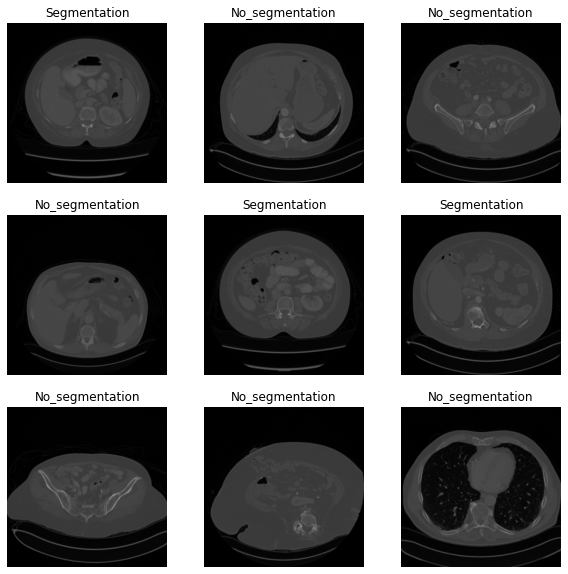

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")